In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from utils_db import load_table
from preprocess import filter_df, format_df, analyze_df

pd.set_option('display.max_columns', None)

In [2]:
# load table
df_raw = load_table("cars")
df_raw.head()

,car_id,url,brand,model,price,post_code,prod_year,mileage,gearbox,energy,attrs,crawled_at
0,1,https://www.lacentrale.fr/auto-occasion-annonc...,CITROEN,CITROEN C5 AIRCROSS,17 900 €,91380,2021,58 440 km,Automatique,Diesel,"{'Couleur': 'Grey', 'Crit'Air': '', 'Longueur'...",2025-05-22 01:01:11.143096
1,2,https://www.lacentrale.fr/auto-occasion-annonc...,RENAULT,RENAULT ARKANA,14 900 €,91380,2021,97 730 km,Automatique,Hybride essence électrique,"{'Couleur': 'Black', 'Crit'Air': '', 'Longueur...",2025-05-22 01:02:14.256237
2,5,https://www.lacentrale.fr/auto-occasion-annonc...,PEUGEOT,PEUGEOT 308 III SW,15 990 €,78130,2022,125 185 km,Automatique,Diesel,"{'Couleur': 'Gris', 'Crit'Air': '', 'Longueur'...",2025-05-22 02:01:43.181004
3,6,https://www.lacentrale.fr/auto-occasion-annonc...,PEUGEOT,PEUGEOT 2008 II,14 900 €,91260,2020,62 285 km,Automatique,Essence,"{'Couleur': 'Orange', 'Crit'Air': '', 'Longueu...",2025-05-22 02:02:23.869099
4,7,https://www.lacentrale.fr/auto-occasion-annonc...,DACIA,DACIA LODGY phase 2,12 980 €,78711,2021,76 872 km,Manuelle,Diesel,"{'Couleur': 'Blanc', 'Crit'Air': '', 'Longueur...",2025-05-22 02:02:52.591344


In [3]:
df = filter_df(df_raw)
df = format_df(df)
df.head()

,brand,model,price,post_code,prod_year,mileage,gearbox,energy,Couleur,Longueur,Norme euro,Provenance,Puissance DIN,Première main,Emission de CO2,Nombre de places,Nombre de portes,Puissance fiscale,Contrôle technique,circulation_year
0,CITROEN,CITROEN C5 AIRCROSS,17900,91,2021,58440,Automatique,Diesel,Grey,4.50,EURO6,Non renseignée,131,Oui,138,5,5,7,Non requis,2021
1,RENAULT,RENAULT ARKANA,14900,91,2021,97730,Automatique,Hybride essence électrique,Black,4.57,EURO6,Non renseignée,145,Oui,108,5,5,5,Non requis,2021
2,PEUGEOT,PEUGEOT 308 III SW,15990,78,2022,125185,Automatique,Diesel,Gris,4.64,EURO6,Non renseignée,131,Oui,122,5,5,7,Non requis,2022
3,PEUGEOT,PEUGEOT 2008 II,14900,91,2020,62285,Automatique,Essence,Orange,4.30,EURO6,Non renseignée,130,Oui,139,5,5,6,Requis,2020
4,DACIA,DACIA LODGY phase 2,12980,78,2021,76872,Manuelle,Diesel,Blanc,4.50,EURO6,Non renseignée,116,Oui,125,5,5,6,Requis,2021


In [4]:
analyze_df(df)


-- shape --

(937, 20)

-- data type --

brand                  object
model                  object
price                   int64
post_code              object
prod_year               int64
mileage                 int64
gearbox                object
energy                 object
Couleur                object
Longueur              float64
Norme euro             object
Provenance             object
Puissance DIN           int64
Première main          object
Emission de CO2         int64
Nombre de places        int64
Nombre de portes        int64
Puissance fiscale       int64
Contrôle technique     object
circulation_year        int32
dtype: object

-- unique values count --

brand                  42
model                 446
price                 463
post_code              74
prod_year              26
mileage               875
gearbox                 2
energy                  8
Couleur               274
Longueur              138
Norme euro              5
Provenance              3
Puis

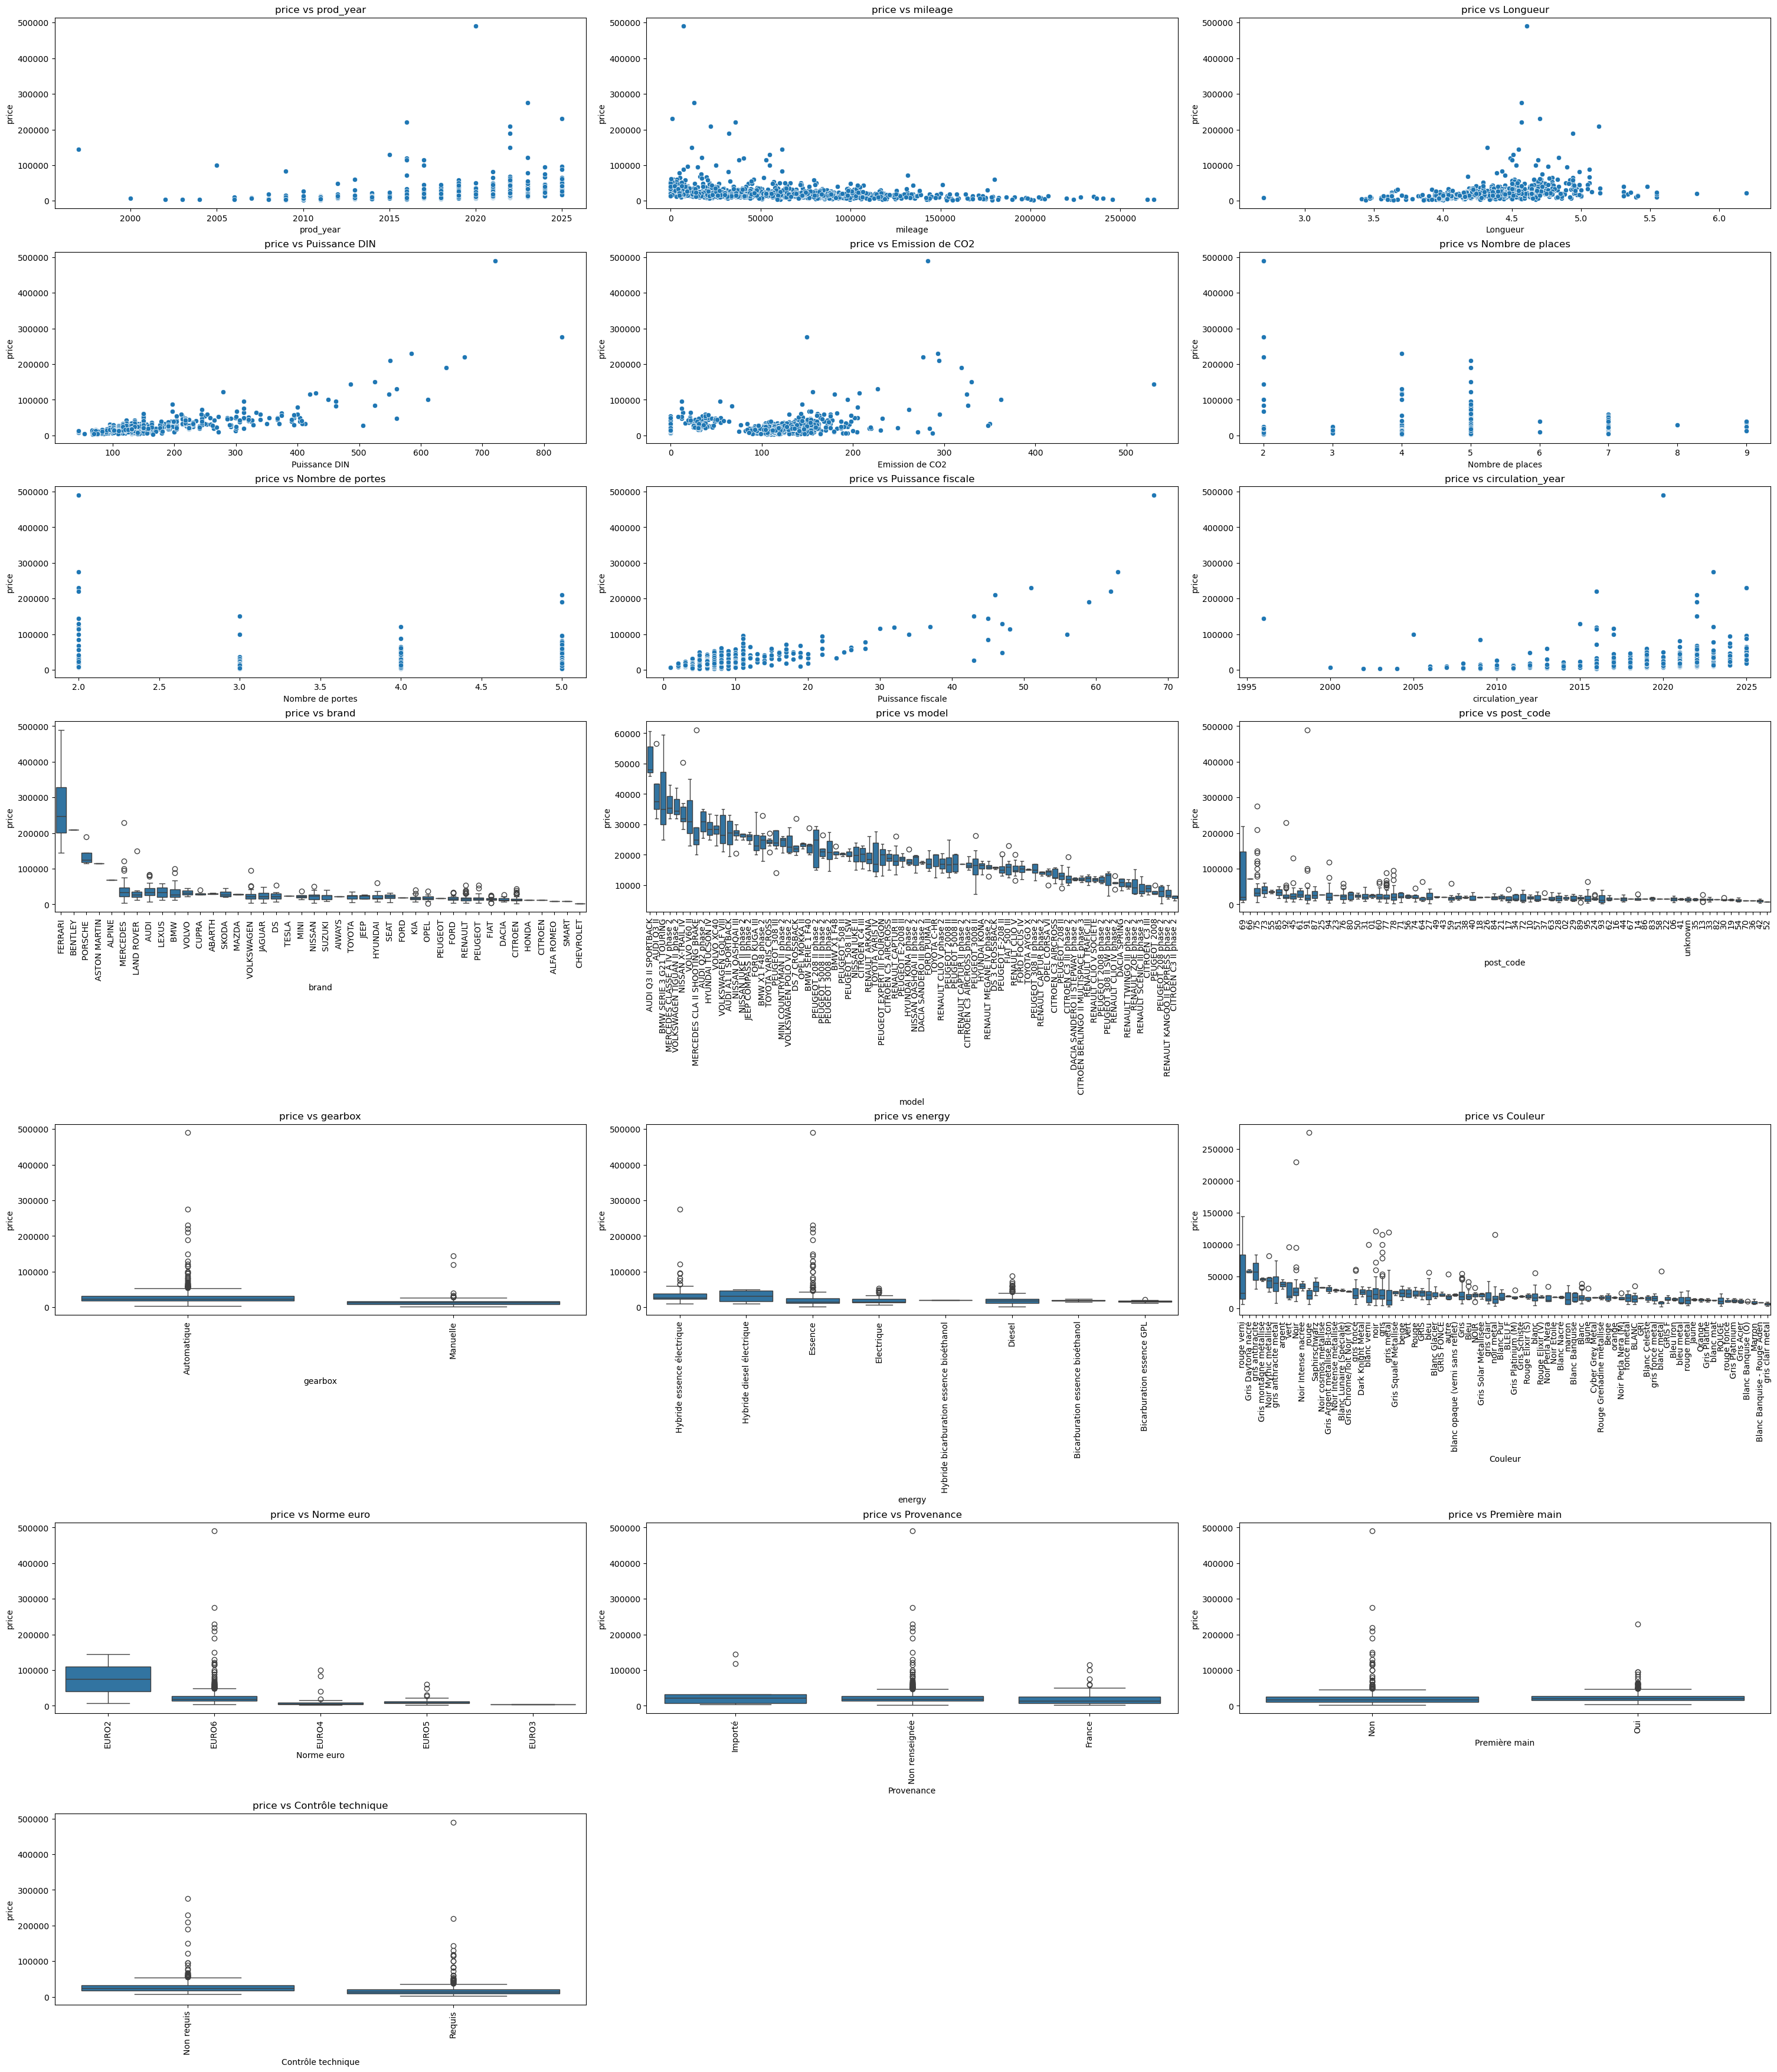

In [5]:
def plot_price_vs_features(df: pd.DataFrame):
    target_col = "price"
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    numerical_cols.remove(target_col)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    all_cols = numerical_cols + categorical_cols
    
    c = 3
    r = math.ceil(len(all_cols) / c)
    fig, axes = plt.subplots(r, c, figsize=(c * 10, r * 5), constrained_layout=True)
    axes = axes.flatten()
    threshold = 80
    
    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in numerical_cols:
            sns.scatterplot(data=df, x=col, y=target_col, ax=ax)
        else:
            top_categories = df[col].value_counts().nlargest(threshold).index.tolist()
            df_filtered = df[df[col].isin(top_categories)]
            categories = (
                df_filtered.groupby(col)[target_col]
                .mean()
                .sort_values(ascending=False)
                .index
                .tolist()
            )
            sns.boxplot(data=df_filtered, x=col, y=target_col, ax=ax, order=categories)
            ax.tick_params(axis='x', labelrotation=90)
        ax.set_title(f"{target_col} vs {col}")
    # Hide unused axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.show()


plot_price_vs_features(df)